# Plot model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from torch import load

from wmpgnn.configs.config_loader import ConfigLoader
#from wmpgnn.model.model_loader import ModelLoader

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


In [6]:
# Define the config files to compare
configs_to_compare = {
    "mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    #"mlp_het": "heteromp_gnn_run3.yaml",
}

# Load the config files
config_loader,datasets = {},{}
models = {}
for label, yml in configs_to_compare.items():
    config_loader[label] = ConfigLoader(f"config_files/{yml}", environment_prefix="DL")
    flatten_config = flatten_dict(config_loader[label].config)
    model_file = config_loader[label].get("training.model_file")
    csv_file = model_file.format(**flatten_config).replace(".pt",".csv")
    datasets[label] = pd.read_csv(csv_file)
    #models[label] = ModelLoader(config_loader).get_model()

In [14]:
# Define the output folders to compare
configs_to_compare = {
    #"full_sim" : "Final_heterogeneous_8block_10_epochs_message_passing_BCE",
    #"onlyLong" : "Final_heterogeneous_8block_10_epochs_message_passing_BCE_onlyLong15k",
    #"onlyLong+3e-3LR": "Final_heterogeneous_8block_10_epochs_message_passing_BCE_onlyLong15k_x3LR",
    #"onlyLong+2e-3LR_80k": "Final_heterogeneous_8block_10_0.002LR_epochs_message_passing_BCE_onlyLong80k",
    #"onlyLong+2e-3LR_80k_10block": "Final_heterogeneous_10block_10_0.002LR_epochs_message_passing_BCE_onlyLong80k",
    "+2e-3LR_80k_10block_40epochs": "Final_heterogeneous_10block_40_0.002LR_epochs_message_passing_BCE_onlyLong80k",
}

# Load the config files
datasets = {}
models = {}
for label, folder in configs_to_compare.items():
    model_file = f"outputs/{folder}/{folder}.pt"
    csv_file = f"outputs/{folder}/{folder}.csv"
    datasets[label] = pd.read_csv(csv_file)

## loss

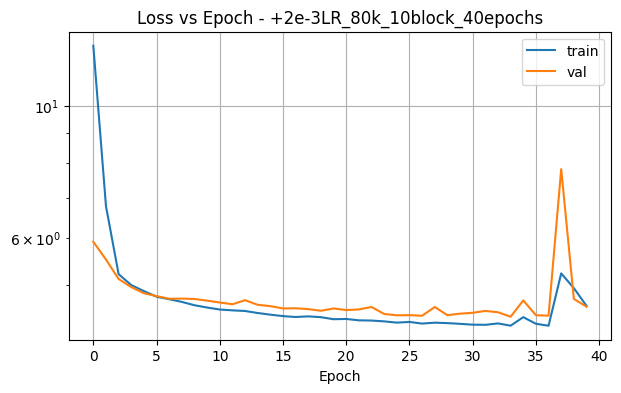

In [15]:
models = list(datasets.keys())

Nmodels = len(models)
fig, axs = plt.subplots(Nmodels, 1, figsize=(7,4*Nmodels))
if Nmodels == 1:
    axs = [axs]
for i,label in enumerate(datasets.keys()):
    axs[i].plot(datasets[label][f"train_loss"], label=f"train")
    axs[i].plot(datasets[label][f"val_loss"], label=f"val")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    #axs[i].set_xlim(8, 11)
    #axs[i].set_ylim(1, 6)
    axs[i].set_yscale('log')
    axs[i].set_title(f"Loss vs Epoch - {label}")
    axs[i].legend()
plt.show()

## metrics

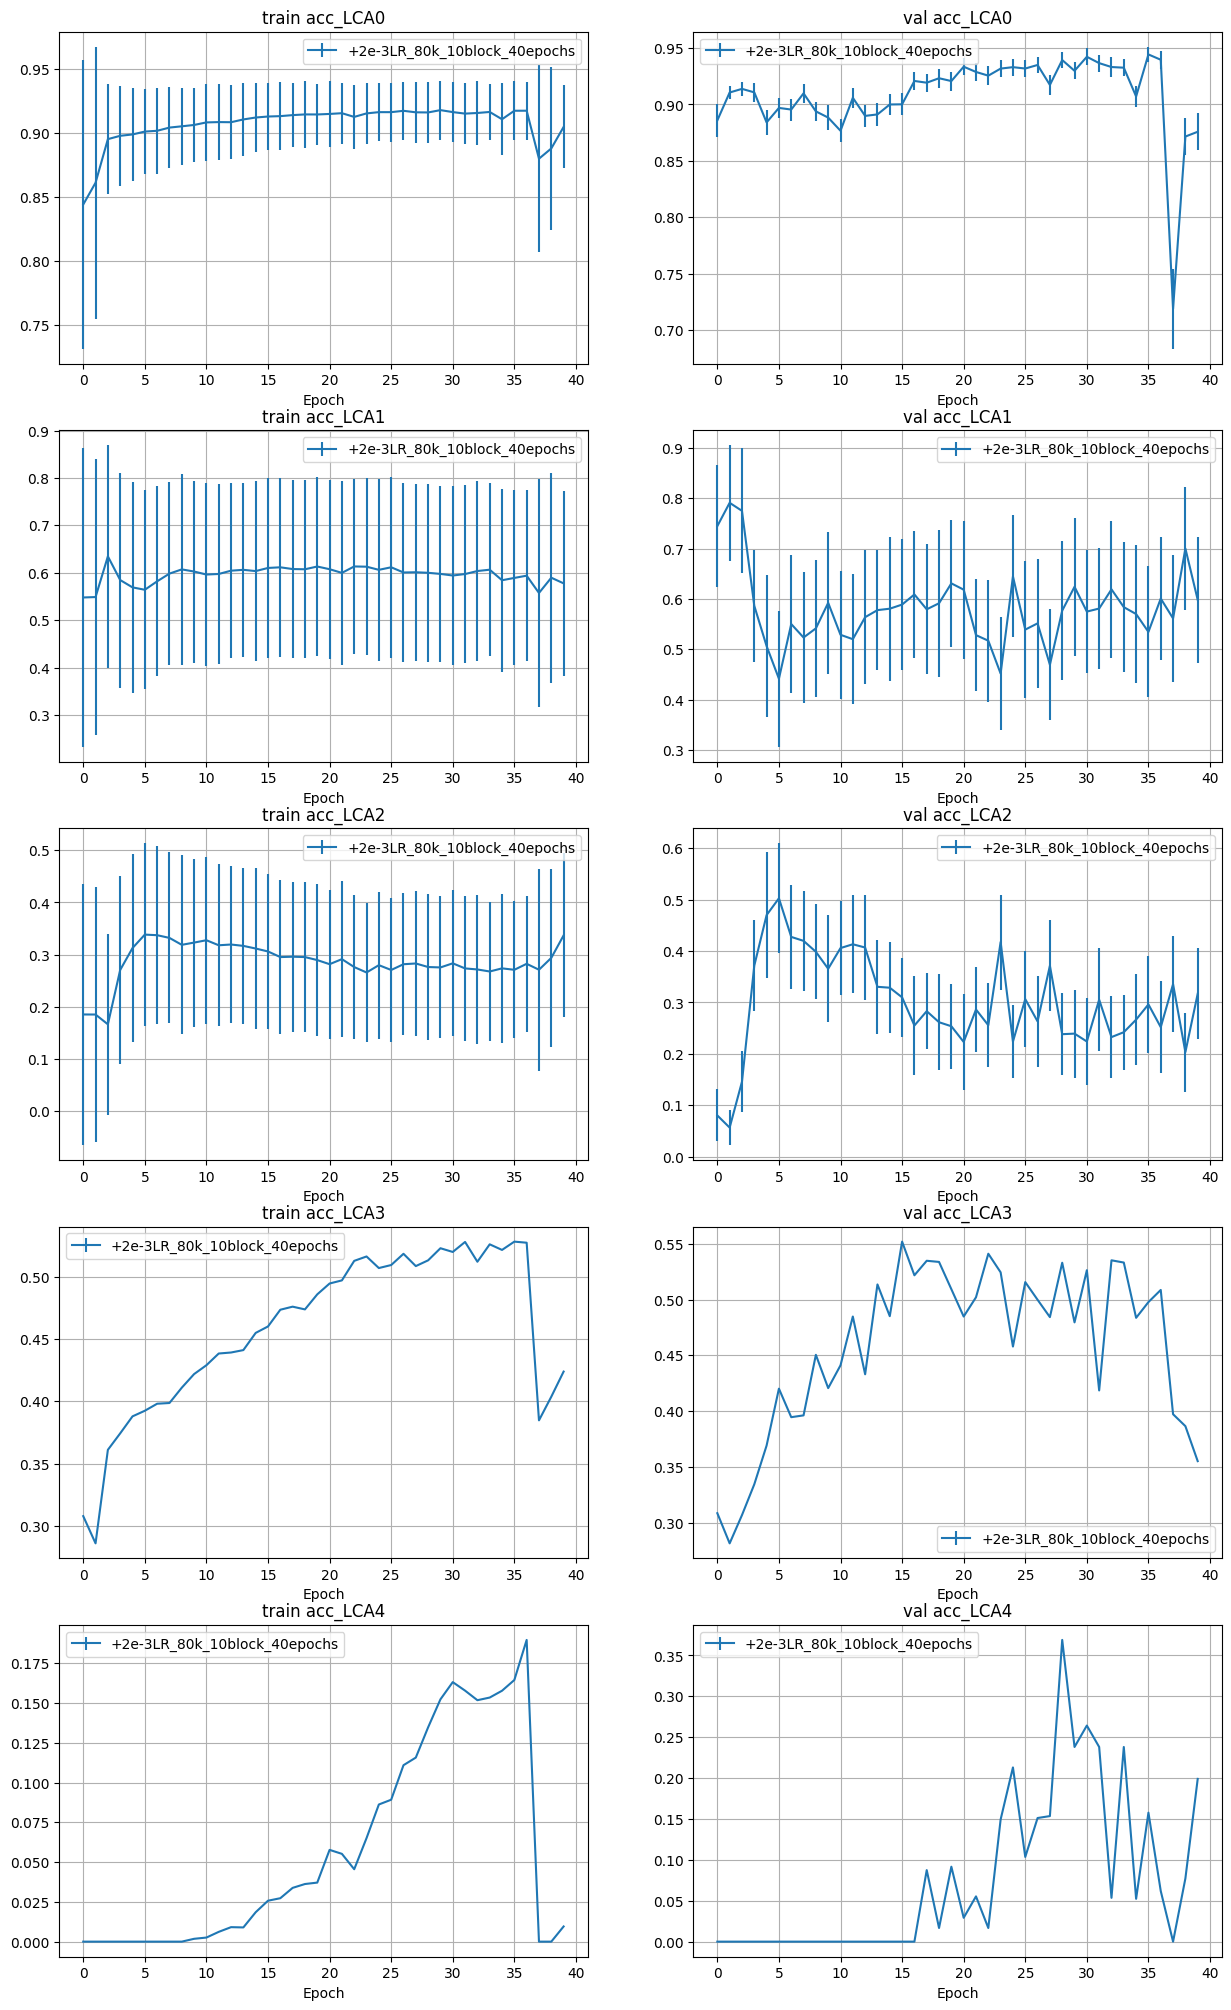

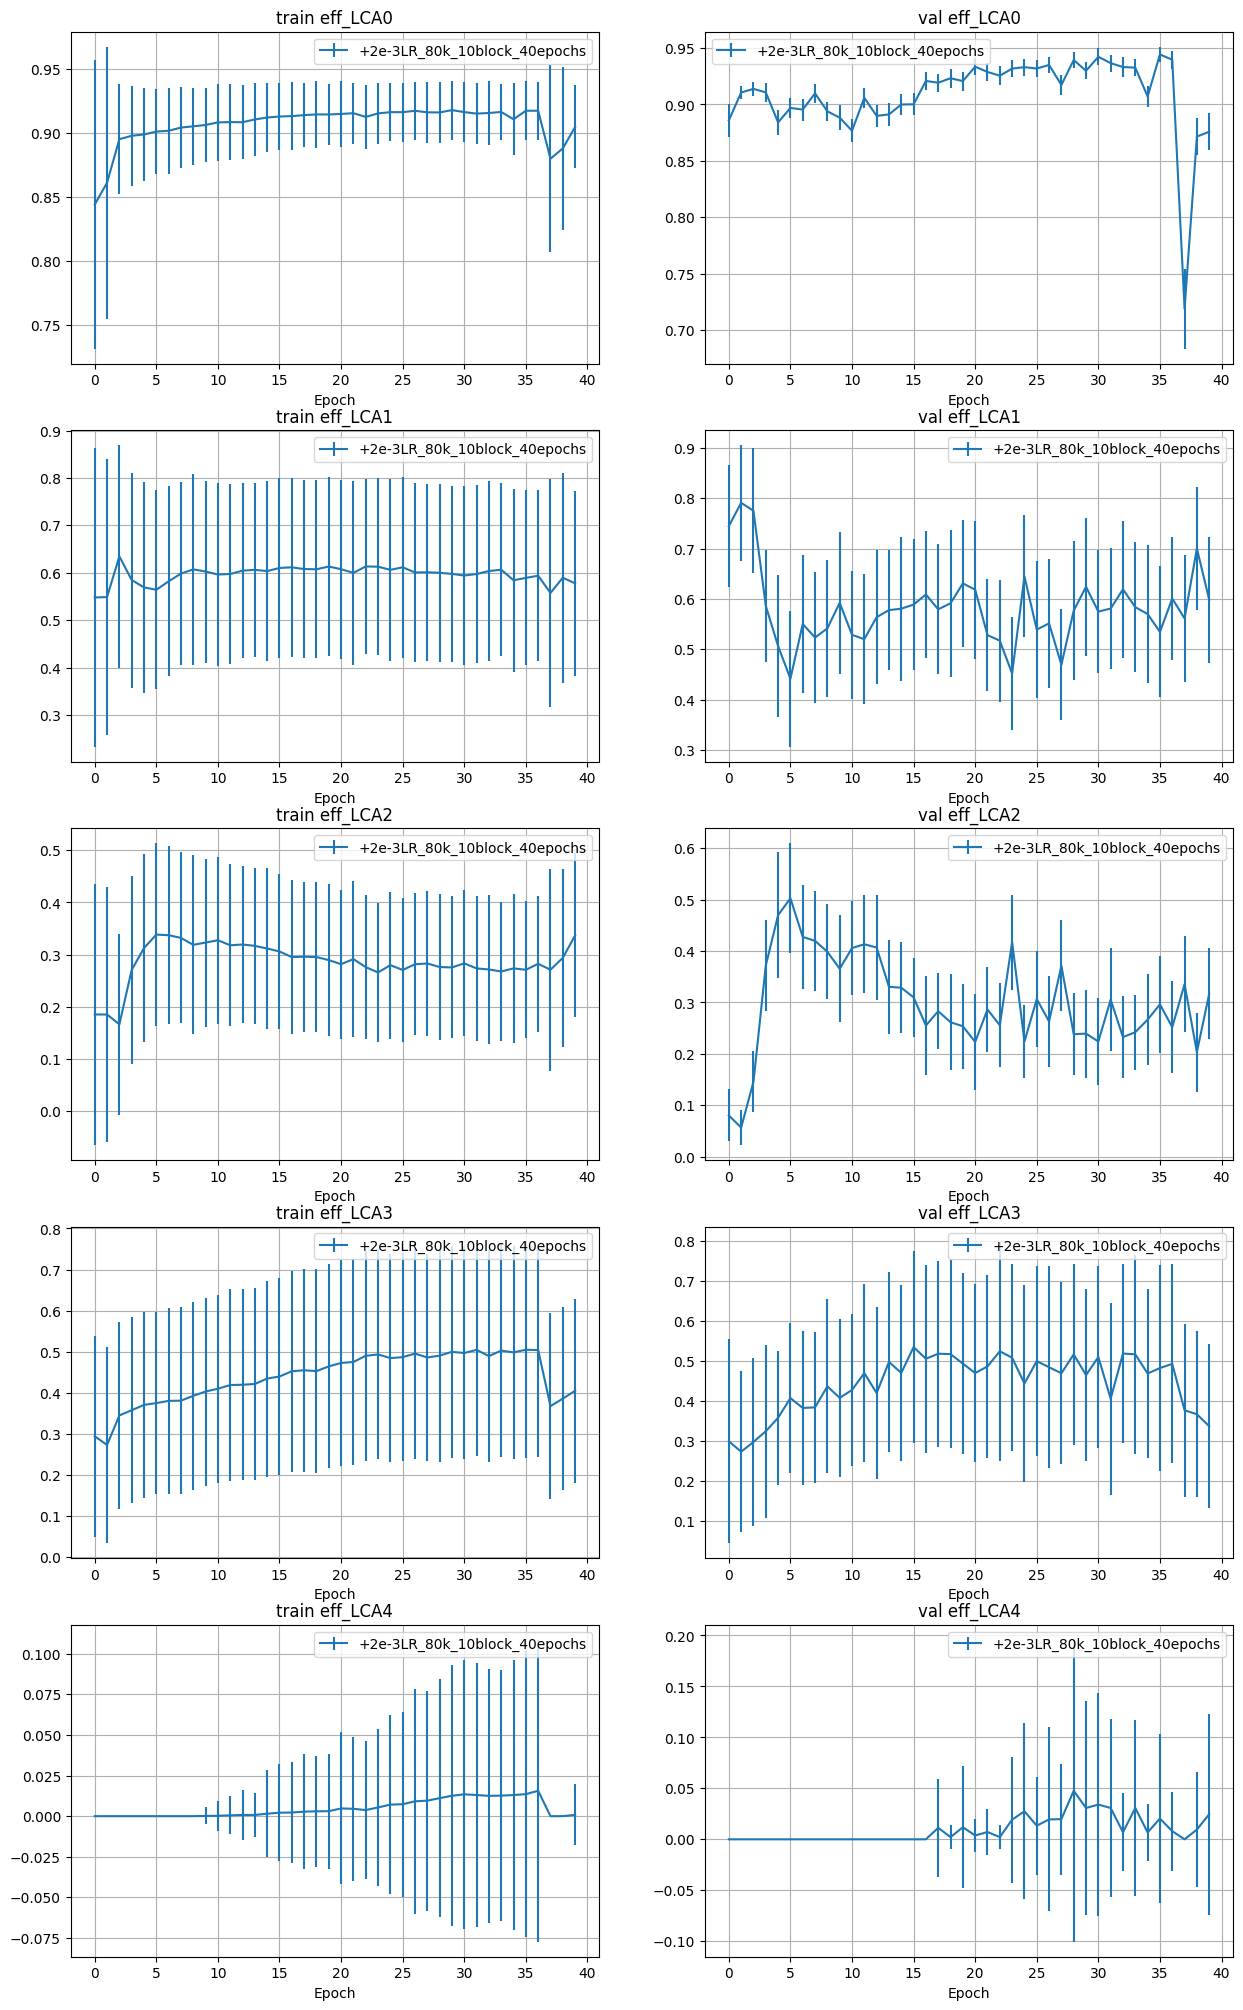

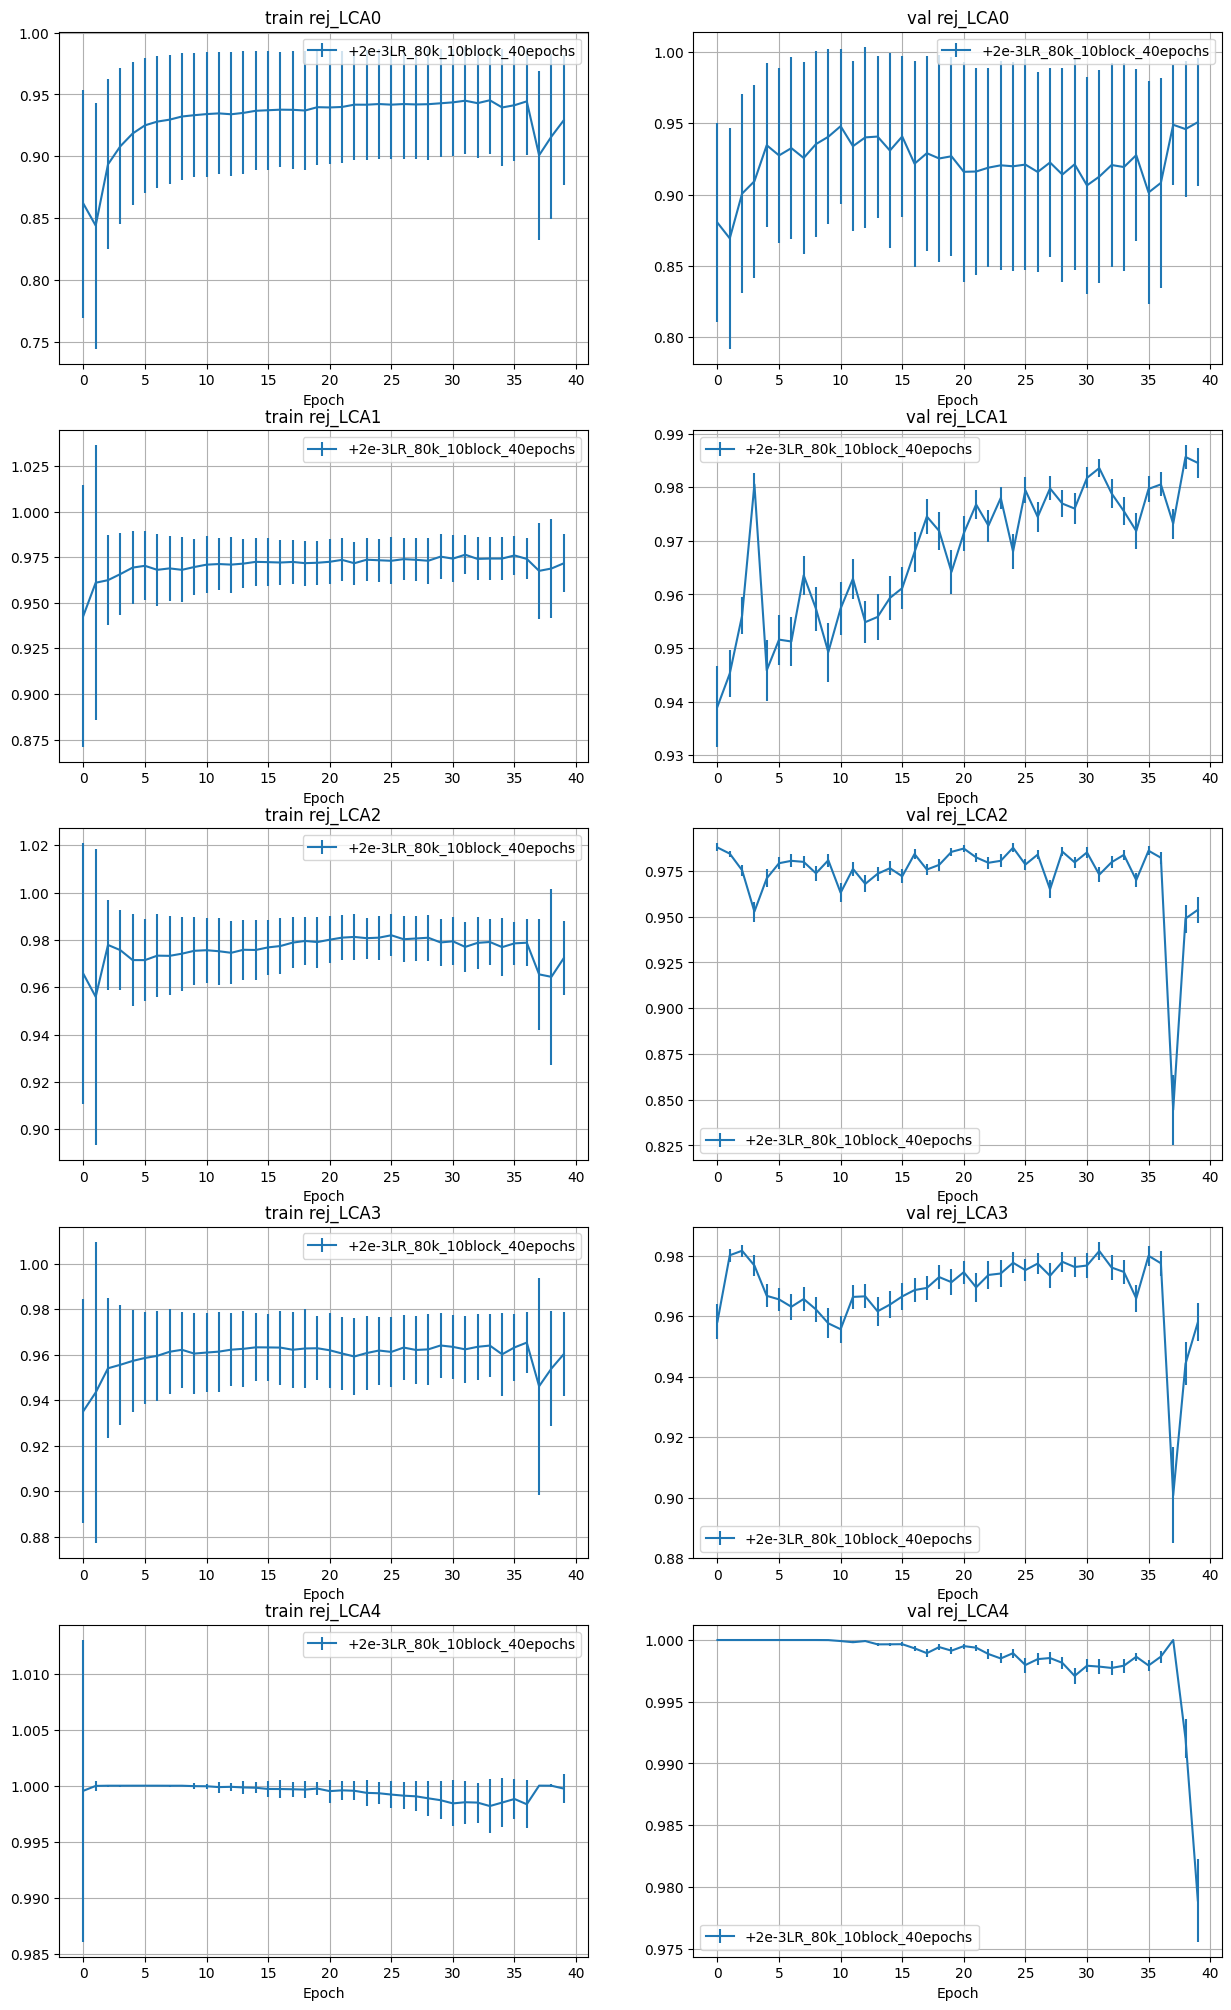

In [17]:
def SmartPlot(ax,x,y,**kwargs):
    """ plot over axes depending on the inputs"""
    yerr = kwargs.get('yerr', None)
    
    if yerr is not None:
        ax.errorbar(x, y, **kwargs)
    else:
        ax.plot(x, y, **kwargs)
    
    return ax

def PlotMetric(datasets,metric='acc'):
    """ plot the metric for each model """
    
    features = [metric+f'_LCA{i}' for i in range(5)] #['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

    Nfeatures = len(features)
    fig, axs = plt.subplots(Nfeatures, 2, figsize=(15, 5*Nfeatures))
    for i, feature in enumerate(features):
        for label in configs_to_compare.keys():
            axs[i,0] = SmartPlot(axs[i,0],datasets[label].index, datasets[label][f"train_{feature}"],yerr=datasets[label][f"train_{feature}_err"], label=label)
            axs[i,1] = SmartPlot(axs[i,1],datasets[label].index, datasets[label][f"val_{feature}"],yerr=datasets[label][f"val_{feature}_err"], label=label)
            #axs[i,0].plot(datasets[label][f"train_{feature}"], label=label)
            #axs[i,1].plot(datasets[label][f"val_{feature}"], label=label)
            
            axs[i,0].set_title(f"train {feature}")
            axs[i,1].set_title(f"val {feature}")
            
        for ax in axs[i]:
            ax.set_xlabel('Epoch')
            ax.grid()
            #ax.set_title(feature)
            ax.legend()

def PlotMetricComb(datasets,metric='acc'):
    """ plot the metric for each model """
    
    features = [metric+f'_LCA{i}' for i in range(5)] #['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

    Nfeatures = len(features)
    fig, axs = plt.subplots(Nfeatures, 1, figsize=(8, 5*Nfeatures))
    for i, feature in enumerate(features):
        for label in configs_to_compare.keys():
            axs[i] = SmartPlot(axs[i],datasets[label].index, datasets[label][f"train_{feature}"],yerr=datasets[label][f"train_{feature}_err"], label=label)
            axs[i] = SmartPlot(axs[i],datasets[label].index, datasets[label][f"val_{feature}"],yerr=datasets[label][f"val_{feature}_err"], label=label)
            #axs[i].plot(datasets[label][f"train_{feature}"], label=f"train_{label}")
            #axs[i].plot(datasets[label][f"val_{feature}"], label=f"val_{label}")

        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_title(feature)
        axs[i].legend()
        
PlotMetric(datasets,metric='acc')
PlotMetric(datasets,metric='eff')
PlotMetric(datasets,metric='rej')

#PlotMetricComb(datasets,metric='acc')
#PlotMetricComb(datasets,metric='eff')
#PlotMetricComb(datasets,metric='rej')

## Heterogeneous model

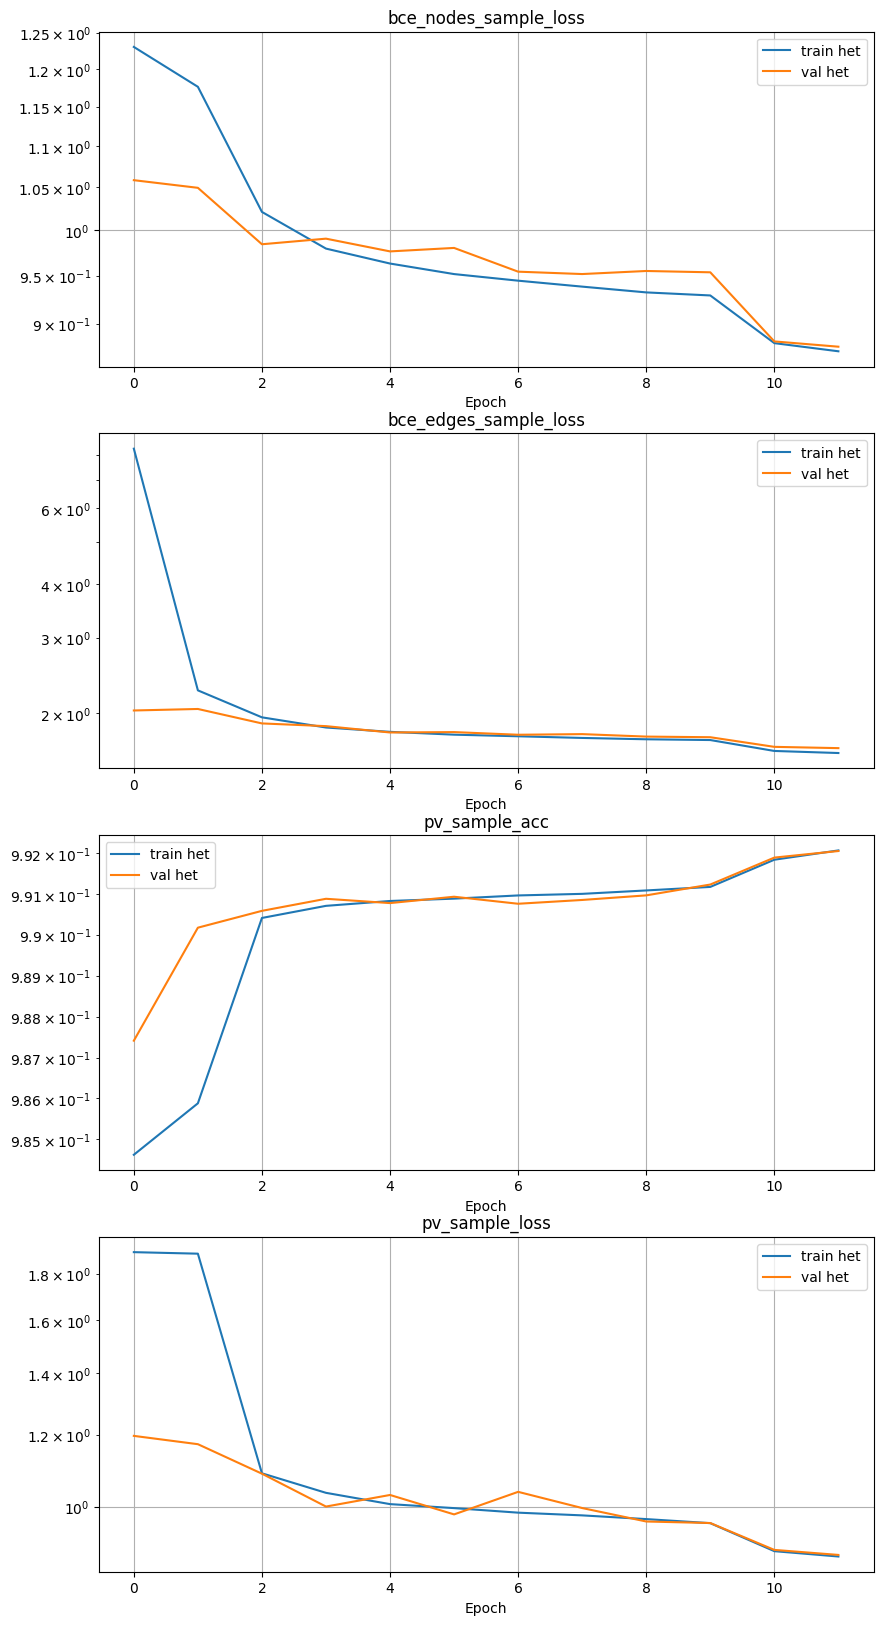

In [33]:
features = ['bce_nodes_sample_loss',
       'bce_edges_sample_loss', 'pv_sample_acc', 'pv_sample_loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    for sample in ['train','val']:
        axs[i].plot(datasets["onlyLong+2e-3LR_80k_10block"][feature.replace("sample",sample)], label=f"{sample} het")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_yscale('log')
    axs[i].set_title(feature)
    axs[i].legend()

## Checkpoint loader

In [29]:
checkpoint['history'].keys()

dict_keys(['train_loss', 'train_acc', 'train_eff', 'train_rej', 'train_acc_err', 'train_eff_err', 'train_rej_err', 'val_loss', 'val_acc', 'val_eff', 'val_rej', 'val_acc_err', 'val_eff_err', 'val_rej_err', 'ce_train_loss', 'ce_val_loss', 'bce_nodes_train_loss', 'bce_nodes_val_loss', 'bce_edges_train_loss', 'bce_edges_val_loss', 'bce_pvs_train_loss', 'bce_pvs_val_loss', 'train_pv_acc', 'train_pv_acc_err', 'val_pv_acc', 'val_pv_acc_err', 'train_node_pv_acc', 'train_node_pv_acc_err', 'val_node_pv_acc', 'val_node_pv_acc_err'])

In [5]:
def FormatHistory(history):
    """return a dictionary with the history of the training for each metrics and class"""
    metrics = {
        'train' : {},
        'val' : {}
    }
    length = len(history['train_loss'])
    for sample in metrics.keys():
        metrics[sample]['loss'] = history[f"{sample}_loss"]
        for metric in ['acc','eff','rej']:
            metrics[sample][metric] = np.array([history[f"{sample}_{metric}"][i] for i in range(length)])
            metrics[sample][metric+'_err'] = np.array([history[f"{sample}_{metric}_err"][i] for i in range(length)])
            for metric in ['bce_nodes','bce_edges','bce_pvs']:
                try:
                    metrics[sample][metric+'_loss'] = np.array([history[f"{metric}_{sample}_loss"][i] for i in range(length)])
                except KeyError:
                    print(f"KeyError: {metric}_{sample}_loss not found in history")
            for metric in ['pv_acc','pv_acc_err','node_pv_acc','node_pv_acc_err']:
                try:
                    metrics[sample][metric] = np.array([history[f"{sample}_{metric}"][i] for i in range(length)])
                except KeyError:
                    print(f"KeyError: {sample}_{metric} not found in history")
    return metrics

# Define the config files to compare
configs_to_compare = {
    #"mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    "mlp_het": "heteromp_gnn_run3_onlyLong.yaml",
}


config_loader = ConfigLoader(f"config_files/{configs_to_compare['mlp_het']}", environment_prefix="DL")
flatten_config = flatten_dict(config_loader.config)
model_file = config_loader.get("training.model_file").format(**flatten_config)
checkpoint_folder = model_file.replace(".pt","")
checkpoint_files = glob.glob(f"outputs/{checkpoint_folder}/checkpoint*")
histories = {}
for chk_file in checkpoint_files:
    # extrack epoch from filename
    checkpoint = load(chk_file,weights_only=True)
    histories[checkpoint['epoch_warmstart']] = FormatHistory(checkpoint['history'])

add_dataset = True
csv_file = model_file.replace(".pt",".csv")
try:
    dataset = pd.read_csv(f"outputs/{checkpoint_folder}/{csv_file}")
except FileNotFoundError:
    add_dataset = False

IndexError: index 5 is out of bounds for axis 1 with size 5

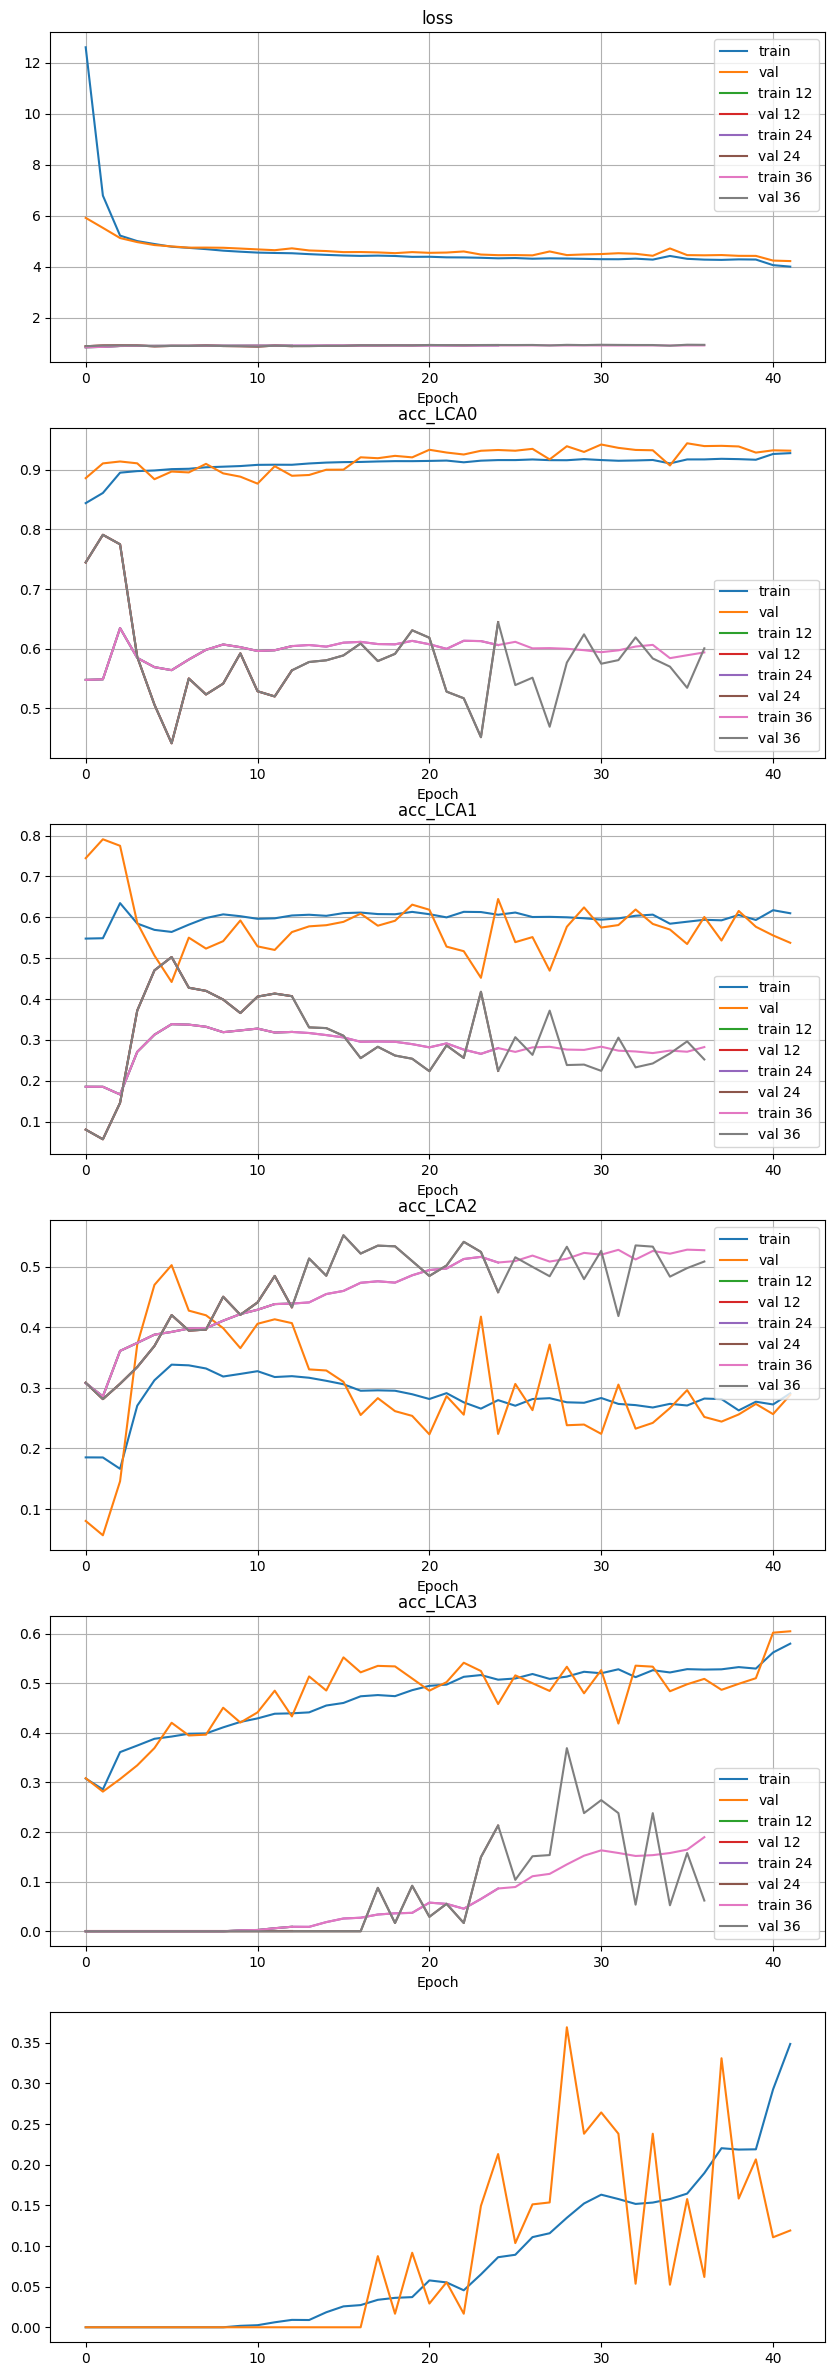

In [8]:
features = ['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    
    if add_dataset:
        axs[i].plot(dataset[f"train_{feature}"], label=f"train")
        axs[i].plot(dataset[f"val_{feature}"], label=f"val")
    
    # add checkpoints
    for epoch,history in histories.items():
        length = history['train']['acc'].shape[0]
        x = np.arange(0, epoch+1)
        axs[i].plot(x,history['train']['acc'][:,i], label=f"train {epoch}")
        axs[i].plot(x,history['val']['acc'][:,i], label=f"val {epoch}")
    
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_title(feature)
    axs[i].legend()
    


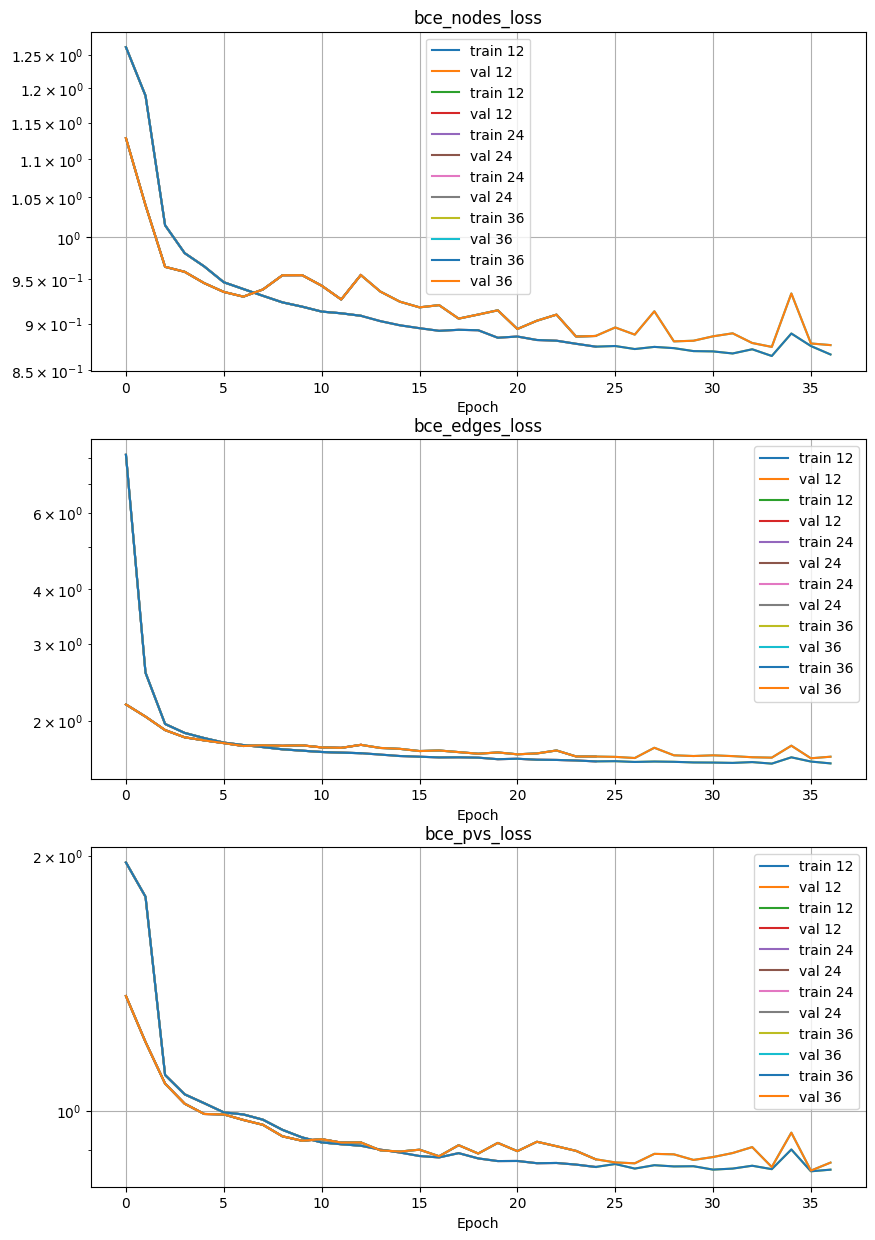

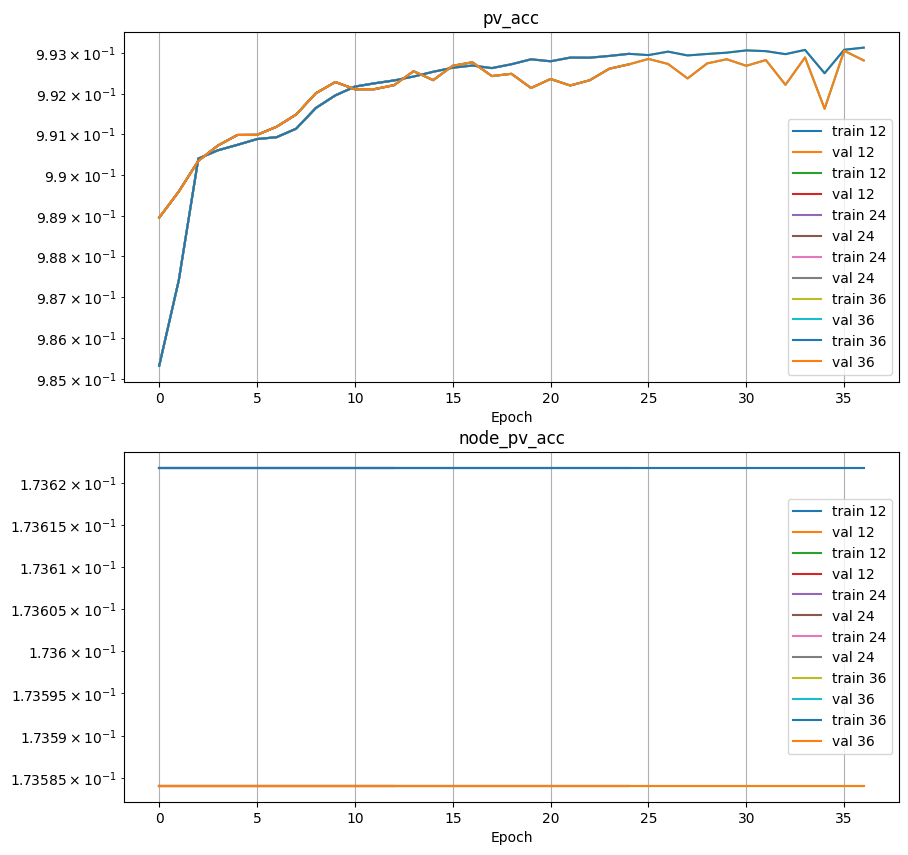

In [7]:
# for heterogeneous model only
features = ['bce_nodes_loss', 'bce_edges_loss', 'bce_pvs_loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for epoch,history in histories.items():
    for i, feature in enumerate(features):
        for sample in ['train','val']:
            axs[i].plot(history['train'][feature], label=f"train {epoch}")
            axs[i].plot(history['val'][feature], label=f"val {epoch}")
            #axs[i].plot(dataset[feature.replace("sample",sample)], label=f"{sample} mlp_het")
        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_yscale('log')
        axs[i].set_title(feature)
        axs[i].legend()
    
features = ['pv_acc', 'node_pv_acc']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for epoch,history in histories.items():
    x = np.arange(0, epoch+1)
    for i, feature in enumerate(features):
        for sample in ['train','val']:
            axs[i].plot(history['train'][feature], label=f"train {epoch}")
            axs[i].plot(history['val'][feature], label=f"val {epoch}")
            #axs[i].plot(dataset[feature.replace("sample",sample)], label=f"{sample} mlp_het")
        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_yscale('log')
        axs[i].set_title(feature)
        axs[i].legend()

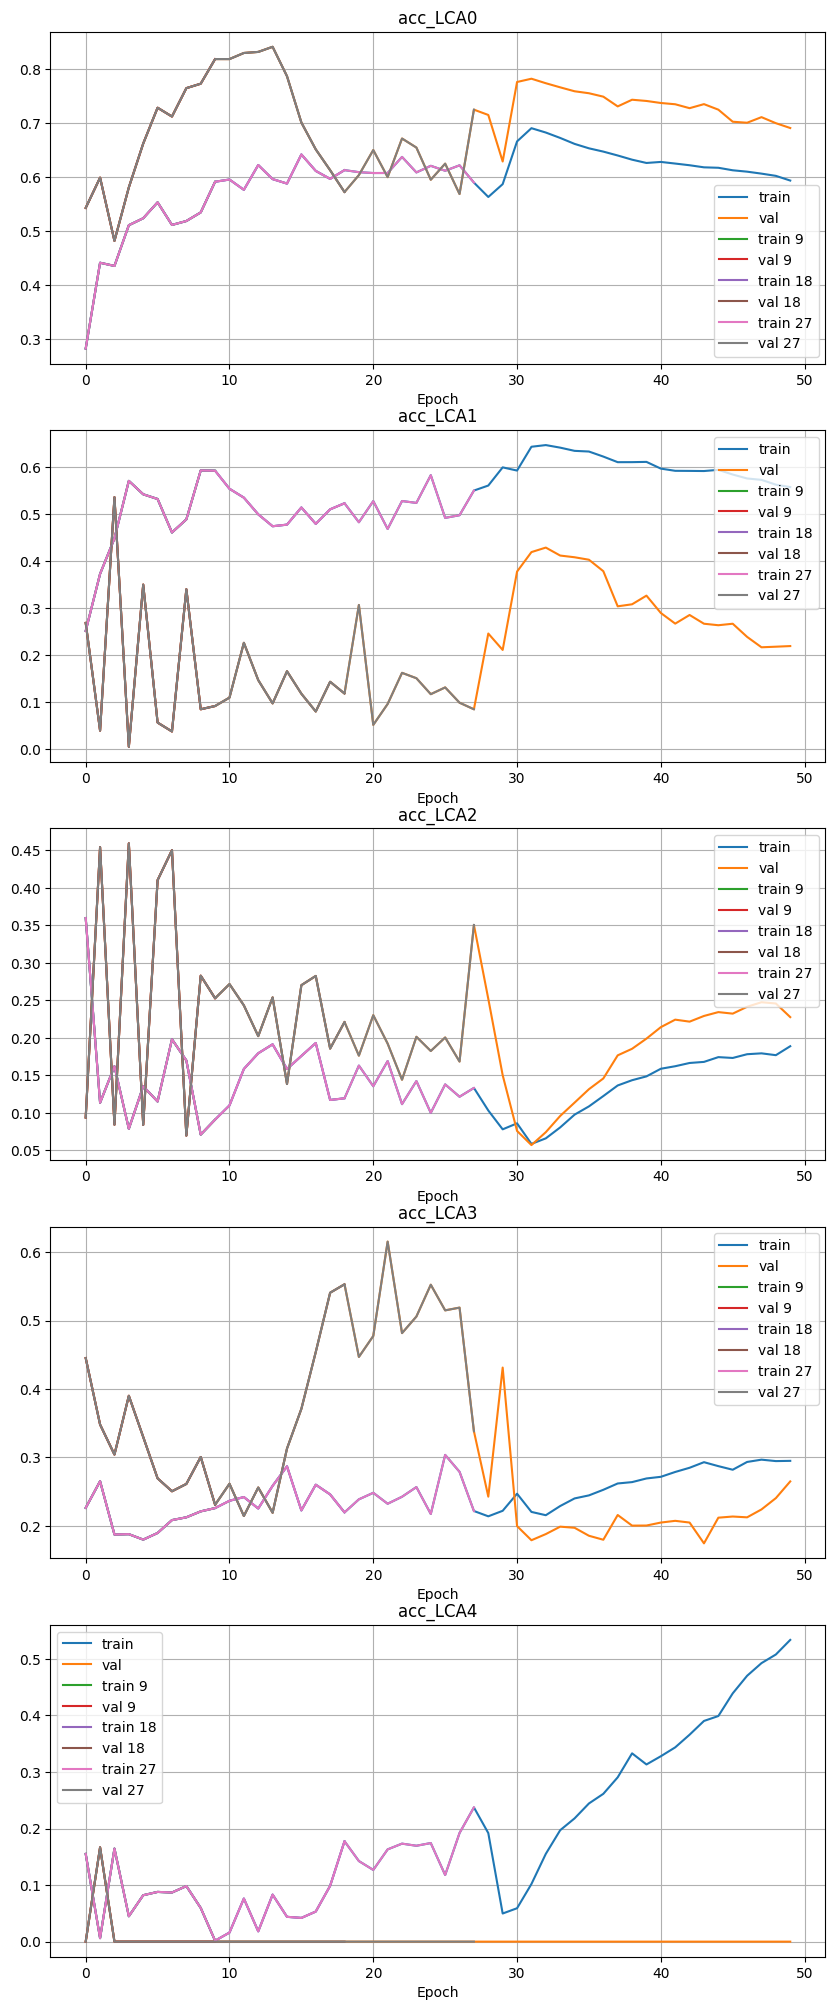

In [27]:
features = ['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    
    axs[i].plot(dataset[f"train_{feature}"], label=f"train")
    axs[i].plot(dataset[f"val_{feature}"], label=f"val")
    
    # add checkpoints
    for epoch,history in histories.items():
        length = history['train']['acc'].shape[0]
        x = np.arange(0, epoch+1)
        axs[i].plot(x,history['train']['acc'][:,i], label=f"train {epoch}")
        axs[i].plot(x,history['val']['acc'][:,i], label=f"val {epoch}")
    
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_title(feature)
    axs[i].legend()